<h1> 5. Interactive Data Analysis </h1>

This notebook introduces carrying out interactive data analysis of data in BigQuery using Cloud Datalab.

This cell, for example, is a mark-down cell.  Which is why you are seeing text. The cell that follows is a Python code cell. The output of that cell is whatever is printed out from it.

In [73]:
a = 3
b = a + 5
print "a={} b={}".format(a,b)

a=3 b=8


Because the markdown comments are HTML, it can even include Javascript, for example to create a table of contents, as shown below:

<div id="toc"></div>

In [74]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h2> Relative path </h2>

I created this notebook in 05_bqdatalab folder of the git repo for the book. So, you will see a path that ends in that. But the path will start with /content which is mapped to a local folder on the computer that is running Datalab.

In [75]:
!pwd

/content/training-data-analyst/flights-data-analysis/05_bqdatalab


<h2> What's installed? </h2>

In [ ]:
!pip freeze

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

<h2> Installing dependencies </h2>

Regular Python dependencies can be installed using pip

In [79]:
!pip install google-cloud

In [77]:
%bash
apt-get update
apt-get -y install python-mpltoolkits.basemap

Get:1 http://security.debian.org jessie/updates InRelease [63.1 kB]
Get:2 http://ftp.us.debian.org testing InRelease [175 kB]
Ign http://deb.debian.org jessie InRelease
Get:3 http://deb.debian.org jessie-updates InRelease [145 kB]
Hit http://deb.debian.org jessie Release.gpg
Hit http://deb.debian.org jessie Release
Get:4 http://ftp.us.debian.org testing/main Sources [9163 kB]
Get:5 http://security.debian.org jessie/updates/main amd64 Packages [430 kB]
Get:6 http://deb.debian.org jessie-updates/main amd64 Packages [17.6 kB]
Get:7 http://deb.debian.org jessie/main amd64 Packages [9064 kB]
Fetched 19.1 MB in 8s (2156 kB/s)
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
python-mpltoolkits.basemap is already the newest version.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [78]:
!pwd

/content/training-data-analyst/flights-data-analysis/05_bqdatalab


<h2> Juypter magic </h2>

In [80]:
%html
This cell will print out a <b> HTML </b> string.

In [81]:
%bigquery schema --table flights.tzcorr

<h2> Calls to BigQuery </h2>

Let's draw a PDF of different arrival delays

In [90]:
import datalab.bigquery as bq
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE DEP_DELAY >= 10 AND RAND() < 0.01
"""
df = bq.Query(sql).to_dataframe(dialect='standard')

In [91]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,45913.000000,46225.000000
mean,46.042210,50.968459
std,63.669851,61.810103
min,-48.000000,10.000000
25%,11.000000,17.000000
50%,27.000000,30.000000
75%,59.000000,61.000000
max,1267.000000,1252.000000


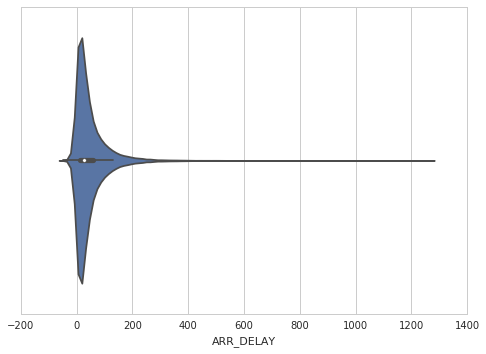

In [92]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')
#ax.axes.set_xlim(0, 30)

In [40]:
import datalab.bigquery as bq
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001
"""
df = bq.Query(sql).to_dataframe(dialect='standard')

In [41]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,20663.000000,20724.000000
mean,4.227073,9.335456
std,40.436516,38.054176
min,-63.000000,-26.000000
25%,-14.000000,-5.000000
50%,-5.000000,-2.000000
75%,7.000000,7.000000
max,1251.000000,1250.000000


In [46]:
df['ontime'] = df['DEP_DELAY'] < 10
df.head()

,ARR_DELAY,DEP_DELAY,ontime
0,-21.0,-4.0,True
1,-5.0,0.0,True
2,99.0,52.0,False
3,-11.0,-7.0,True
4,-4.0,-2.0,True


(-50, 200)

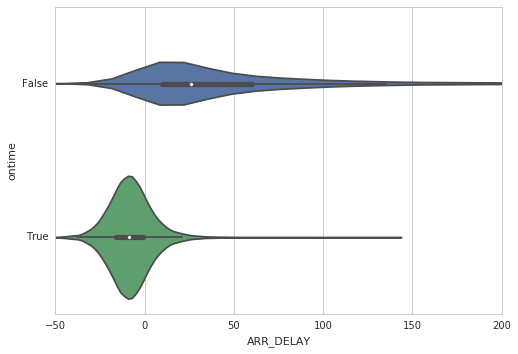

In [53]:
import seaborn as sns
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 200)

(-50, 50)

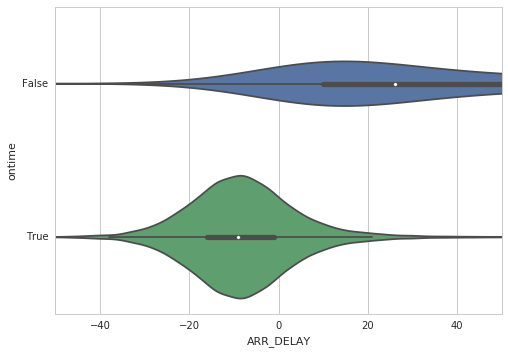

In [57]:
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', 
                    inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 50)

In [65]:
%sql --dialect standard --module depdelayquery
  #standardsql
SELECT
  *
FROM (
  SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY


In [66]:
depdelay = bq.Query(depdelayquery).to_dataframe(dialect='standard')
depdelay[:5]

,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-27.0,-26.793548,10.785545,465
1,-26.0,-24.438375,11.403709,714
2,-25.0,-25.185224,10.598301,961
3,-24.0,-24.090560,12.087346,1303
4,-23.0,-24.016630,11.008934,1804


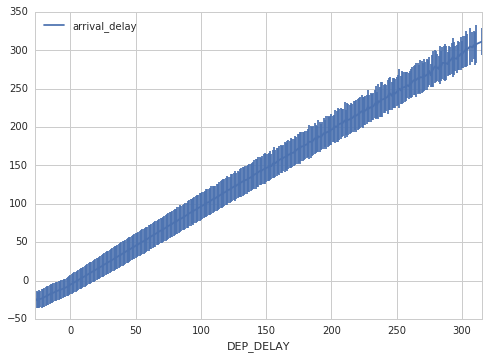

In [68]:
ax = depdelay.plot(kind='line', x='DEP_DELAY', 
              y='arrival_delay', yerr='stddev_arrival_delay')

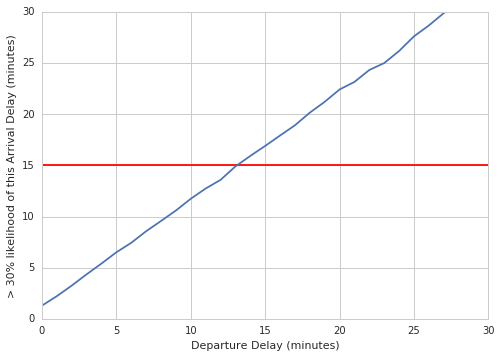

In [70]:
import matplotlib.pyplot as plt
Z_30 = 0.52
depdelay['arr_delay_30'] = (Z_30 * depdelay['stddev_arrival_delay']) \
             + depdelay['arrival_delay']
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arr_delay_30',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)')

In [71]:
%sql --dialect standard --module depdelayquery2
#standardsql
SELECT
  DEP_DELAY,
  arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `cloud-training-demos.flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY

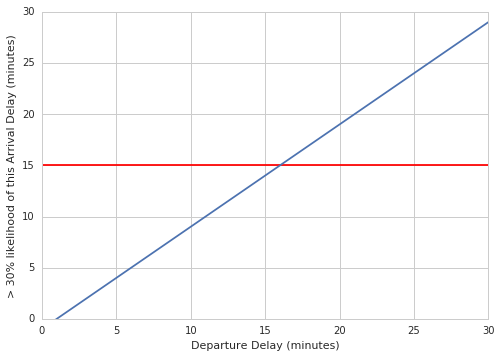

In [72]:
depdelay = bq.Query(depdelayquery2).to_dataframe(dialect='standard')
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)')

In [94]:
%sql --dialect standard --module depdelayquery3
#standardsql
SELECT
  DEP_DELAY,
  arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `cloud-training-demos.flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'True'
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY

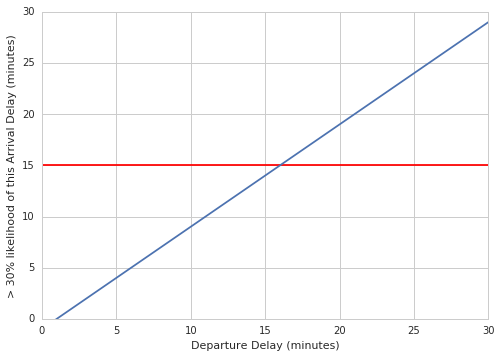

In [95]:
depdelay = bq.Query(depdelayquery3).to_dataframe(dialect='standard')
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)')

In [96]:
%sql --dialect standard --module evalquery
#standardsql
SELECT
  SUM(IF(DEP_DELAY < 16
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY < 16
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False' )

In [97]:
eval = bq.Query(evalquery).to_dataframe(dialect='standard')
print eval['correct_nocancel'] / (eval['correct_nocancel'] + \
eval['wrong_nocancel'])
print eval['correct_cancel'] / (eval['correct_cancel'] + \
eval['wrong_cancel'])

0    0.949629
dtype: float64
0    0.804378
dtype: float64


In [98]:
eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,4493692,238360,188140,773612


In [99]:
%sql --dialect standard --module evalquery2
#standardsql
SELECT
  SUM(IF(DEP_DELAY = 15
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY = 15
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False' )

In [100]:
eval = bq.Query(evalquery2).to_dataframe(dialect='standard')
eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,27200,10391,24005,10408


In [101]:
print eval['correct_nocancel'] / (eval['correct_nocancel'] + \
eval['wrong_nocancel'])
print eval['correct_cancel'] / (eval['correct_cancel'] + \
eval['wrong_cancel'])

0    0.723577
dtype: float64
0    0.302444
dtype: float64
